In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
utils.to_categorical
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [ ]:
np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data= pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data= pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data= pickle.load(f)

print(type(train_data))
X_train, y_train= train_data['features'],train_data['labels']
X_val, y_val= val_data['features'],val_data['labels']
X_test, y_test= test_data['features'],test_data['labels']

<class 'dict'>


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0]==y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0]==y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images is not equal to the number of labels"

assert(X_train.shape[1:]== (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:]== (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:]== (32,32,3)), "The dimensions of the images are not 32x32x3"

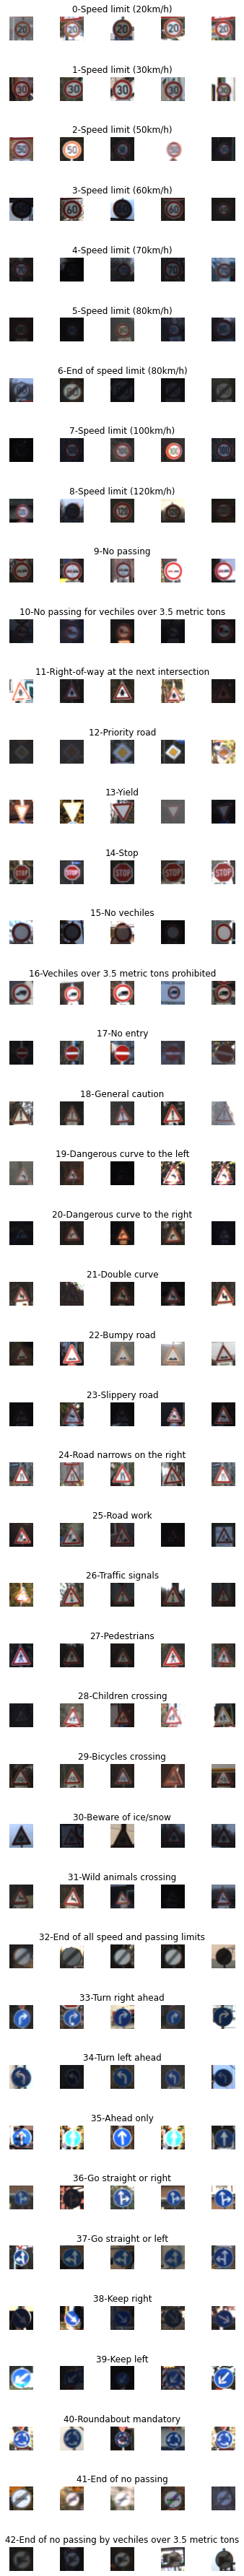

In [ ]:
data=pd.read_csv("german-traffic-signs/signnames.csv")

num_of_samples=[]
cols=5
num_classes=43

fig,axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range (cols):
  for j,row in data.iterrows():
    x_selected= X_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)),:,:], cmap=plt.get_cmap('Greys'))
    axs[j][i].axis("off")
    if i==2:
      axs[j][i].set_title(str(j)+"-"+row["SignName"])
      num_of_samples.append(len(x_selected))



[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


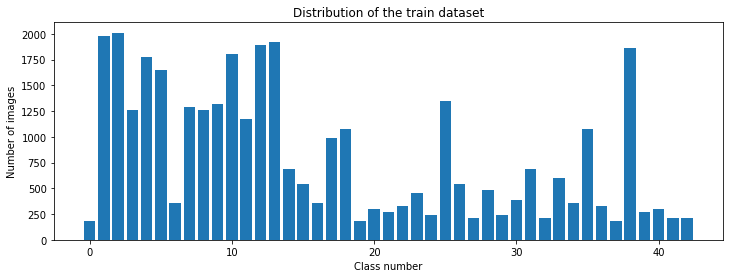

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


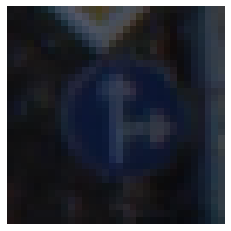

In [ ]:
import cv2
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


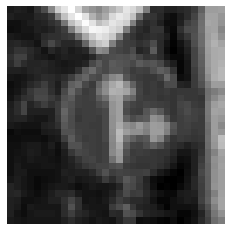

In [ ]:
def grayscale(img):
  img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img= grayscale(X_train[1000])
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

(32, 32)


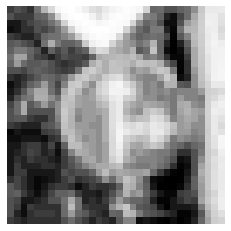

In [ ]:
def equalize(img):
  img= cv2.equalizeHist(img)
  return img

img= equalize(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

In [ ]:
def preprocessing(img):
  img=grayscale(img)
  img=equalize(img)
  img=img/255
  return img

X_train= np.array(list(map(preprocessing, X_train)))
X_val= np.array(list(map(preprocessing, X_val)))
X_test= np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


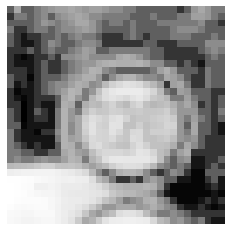

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)],cmap=plt.get_cmap('gray'))
plt.axis("off")
print(X_train.shape)

In [ ]:
X_train= X_train.reshape(34799, 32, 32, 1)
X_test= X_test.reshape(12630, 32, 32, 1)
X_val= X_val.reshape(4410, 32, 32, 1)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(width_shift_range=0.1,
                   height_shift_range=0.1,
                   zoom_range=0.2,
                   shear_range=0.1,
                   rotation_range=10)
datagen.fit(X_train)

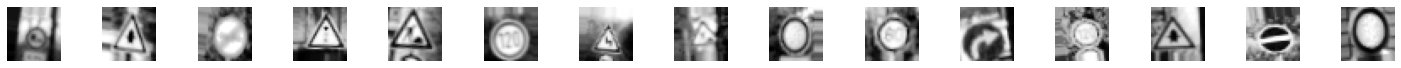

In [ ]:
batches=datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch =next(batches)

fig, axs=plt.subplots(1,15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32), cmap=plt.get_cmap('gray'))
  axs[i].axis('off')

In [ ]:
y_train= utils.to_categorical(y_train, 43)
y_test= utils.to_categorical(y_test, 43)
y_val= utils.to_categorical(y_val, 43)

In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(60, (5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  #Complile Model
  model.compile(Adam(lr=0.001), loss = 'categorical_crossentropy', metrics =['accuracy'])
  return model



In [ ]:
model= modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history= model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=X_train.shape[0]/50, epochs=10, validation_data=(X_val, y_val), shuffle=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
695/695 [==============================] - 26s 19ms/step - loss: 2.1429 - accuracy: 0.3907 - val_loss: 0.5162 - val_accuracy: 0.8558
Epoch 2/10
695/695 [==============================] - 13s 19ms/step - loss: 0.8861 - accuracy: 0.7256 - val_loss: 0.1807 - val_accuracy: 0.9474
Epoch 3/10
695/695 [==============================] - 14s 20ms/step - loss: 0.5956 - accuracy: 0.8126 - val_loss: 0.1057 - val_accuracy: 0.9721
Epoch 4/10
695/695 [==============================] - 15s 22ms/step - loss: 0.4635 - accuracy: 0.8545 - val_loss: 0.0925 - val_accuracy: 0.9769
Epoch 5/10
695/695 [==============================] - 13s 19ms/step - loss: 0.4091 - accuracy: 0.8718 - val_loss: 0.0752 - val_accuracy: 0.9782
Epoch 6/10
695/695 [==============================] - 13s 19ms/step - loss: 0.3378 - accuracy: 0.8924 - val_loss: 0.1087 - val_accuracy: 0.9689
Epoch 7/10
695/695 [==============================] - 13s 19ms/step - loss: 0.3115 - accuracy: 0.9026 - val_loss: 0.0501 - val_accuracy:

Text(0.5, 0, 'Epoch')

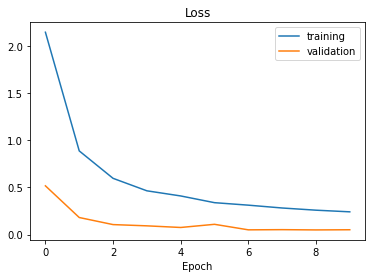

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

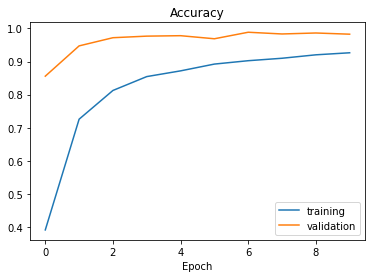

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')

In [ ]:
score= model.evaluate(X_test, y_test, verbose=0)
print('Test Score',score[0])
print('Test Accuracy', score[1])

Test Score 0.15060102939605713
Test Accuracy 0.955898642539978


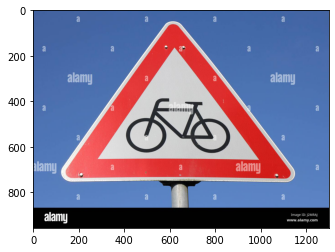

In [ ]:
#fetch image
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


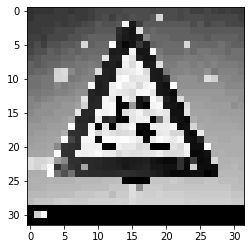

In [ ]:
#Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
img = img.reshape(1, 32, 32, 1)

In [ ]:
pred=np.argmax(model.predict(img), axis=-1)
print("predicted sign: "+ str(pred))

predicted sign: [29]
